# Thickness of the CuOFE and CuCrZr layer

## Figure 5 from thermal analysis paper

- Path to original figure data: smb://fs03/LTH_Neutimag/hkromer/02_Simulations/01_Python/COMSOL_new_target/max_temp_vs_Cu_backing_thickness/max_temp_vs_Cu_backing_thickness.py

- Path to the data: /Users/hkromer/02_PhD/02_Data/01_COMSOL/cfd/Cu_thickness/



In [34]:
import numpy as np
import pandas as pd
import os
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import glob
import re
import copy

In [35]:
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

In [36]:
folder = '/Users/hkromer/02_PhD/02_Data/01_COMSOL/cfd/Cu_thickness'
output_folder = f'/Users/hkromer/02_PhD/04_Publiations/05_Latex/Thesis/Figures/03.RotatingTarget/Cu_thickness/'
# datafile from COMSOL
path_to_data_folder = [0,0]  # 25 rpm, 200 rpm
path_to_data_folder[0] = f"{folder}/run40_lam_CuCrZr"
path_to_data_folder[1] = f"{folder}/run40_lam_CuOFE"
path_to_data_folder

['/Users/hkromer/02_PhD/02_Data/01_COMSOL/cfd/Cu_thickness/run40_lam_CuCrZr',
 '/Users/hkromer/02_PhD/02_Data/01_COMSOL/cfd/Cu_thickness/run40_lam_CuOFE']

,Material,i,j
0,CuCrZr,3,2
1,CuCrZr,2,2
2,CuCrZr,5,2
3,CuCrZr,4,2
4,CuCrZr,3,5


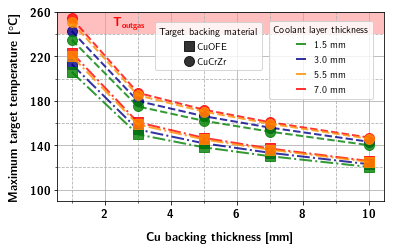

In [50]:
"""
1.) import the data
"""
"""

beam power:			 10 20 60 100 200 W
rotational velocity: 25 rpm

%_i_j:

%   i - water thickness:
CuCrZr
%       2 - water thickness: 1.5 mm
%       3 - water thickness: 3.0 mm
%       4 - water thickness: 5.5 mm
%       5 - water thickness: 7.0 mm
CuOFE
%       6 - water thickness: 1.5 mm
%       7 - water thickness: 3.0 mm
%       8 - water thickness: 5.5 mm
%       9 - water thickness: 7.0 mm


%   j - Cu thickness

%       1 - Cu thickness: 1 mm
%       2 - Cu thickness: 3 mm
%       3 - Cu thickness: 5 mm
%       4 - Cu thickness: 7 mm
%       5 - Cu thickness: 10 mm
"""
# list of the target identifiers
lst_i_LT = [(2, 1.5), (3, 3.0), (4, 5.5), (5, 7.0), (6, 1.5), (7, 3.0), (8, 5.5), (9, 7)] # water thickness
lst_j_LT = [(1, 1), (2, 3), (3, 5), (4, 7), (5, 10)] # Cu thickness


lst_material = []  # CuCrZr or CuOFE
lst_i = []  # water thickness
lst_j = []  # Cu thickness
lst_p = []  # beam powers in W
lst_maxT = []  # maximum target temperatures in K
# files in the directory
for path in path_to_data_folder:
    for name in glob.glob(path + '/*.m'):
        t = re.findall(r'.+(\d_\d).+', name)  # select only _i_j.m
#         print(name, t)
        if len(t) > 0:
            t = re.findall(r'lam\_(\S+)/', name)
            if len(t) > 0:
                lst_material.append(t[0])
            # print(name)
            tt = re.findall(r'maxT\_(\d)\_(\d)', name)
            if len(tt) > 0:
                lst_i.append(int(tt[0][0]))
                lst_j.append(int(tt[0][1]))
            # open file
            # beam power in W, Maximum temperature in K
            df_t = pd.read_csv(name, delimiter=r"\s+", skiprows=5, header=None)
            lst_p.append((df_t.iloc[:,0].values))
            lst_maxT.append((df_t.iloc[:,1].values))

# print(lst_material)
# populate DF
df = pd.DataFrame({'Material': lst_material, 'i': lst_i, 'j': lst_j})

def lookupWaterAndCuThickness(df):
	# water thickness
	# loop through the i
	for item in lst_i_LT:
		if (item[0]) == (df['i']):
			df['Water_thickness_mm'] = item[1]

	# Cu thickness
	# loop through the j
	for item in lst_j_LT:
		if (item[0]) == (df['j']):
			df['Cu_thickness_mm'] = item[1]
	return df

df = df.apply(lookupWaterAndCuThickness, axis=1)

col_names = ['p_beam_' + str(val) + '_W' for val in lst_p[0]]
# add beam power and maximum target temperature
# all the beam powers are the same
for col in col_names:
	df[col] = -1

# populate maximum target temperatures. 5 is 10 W column. Convert from K to C
offset = 5
for jj in range(0,len(lst_maxT)):
	for ii in range(0,len(col_names)):
		df.iloc[jj, ii+offset] = lst_maxT[jj][ii] - 273.15 # degree
	
# unique water thicknesses
dfs_water_thickness = []

lst_unique_water_thicknesses = df['Water_thickness_mm'].unique()

for ii in lst_unique_water_thicknesses:
	dfs_water_thickness.append(df[ df['Water_thickness_mm'] == ii ]  )

# print(dfs_water_thickness)

# -------------------------------------------------------------------
# plot 
# -------------------------------------------------------------------

fig = plt.figure(figsize=(8*0.70,5*0.75))

####################
# axis 1
####################
ax1 = fig.add_subplot(1, 1, 1)

# plot
lst_plot = []
ii = 0
jj = 0
handles = []  # legend handles to change color of legend
color = ['darkblue', 'g', 'red', 'darkorange']
marker = ['s', 'o']
for df in dfs_water_thickness:
    this_color = color[jj]
    jj = jj + 1
    df_CuOFE = df[ df['Material'] == 'CuOFE' ]
    df_CuCrZr = df[ df['Material'] == 'CuCrZr' ]
    for this_df in [df_CuOFE, df_CuCrZr]:
        this_df = this_df.sort_values(by=['Cu_thickness_mm', 'Water_thickness_mm'])
#         print(this_df.info())
        if ii % 2 ==  0:
            this_label = str(this_df['Water_thickness_mm'].iloc[0]) + ' mm'
            this_marker = marker[0]
            this_style = '-.'
        else:
            this_label="_nolegend_"
            this_marker = marker[1]
            this_style = '--'
        
        _, = ax1.plot(this_df['Cu_thickness_mm'], this_df['p_beam_200_W'], this_style, linewidth=2, color=this_color, marker=this_marker, label=this_label, markersize=10, alpha=0.8)
        lst_plot.append(_)
        handles.append(copy.copy(_))
        ii = ii + 1

# axes label
ax1.set_xlabel(r'\textbf{Cu backing thickness [mm]}', fontsize=12, labelpad=10)
ax1.set_ylabel(r'\textbf{Maximum target temperature [$^{\circ}$C]}', fontsize=12, labelpad=10)
plt.ylim(90,260)
# ticks
# ax1.xaxis.set_ticks(df['Cu_thickness_mm'].unique())
ax1.xaxis.set_ticks(np.arange(2,12,2))
ax1.yaxis.set_ticks(np.arange(100,40+260,40))
# minor ticks x
minor_locator = AutoMinorLocator(2)
ax1.xaxis.set_minor_locator(minor_locator)
# minor ticks y
minor_locator = AutoMinorLocator(2)
ax1.yaxis.set_minor_locator(minor_locator)
# tick font size
ax1.tick_params('x', colors='black', labelsize=12)	
ax1.tick_params('y', colors='black', labelsize=12)	
# grid
ax1.grid(b=True, which='major', linestyle='-')#, color='gray')
ax1.grid(b=True, which='minor', linestyle='--')#, color='gray')

# ####################
# # other axis
# ####################
# ax2 = ax1.twinx()
# # plot
# ax2.plot(df['vol_flow_rate_lpmin'], df['Re_number'], '--', marker='D', color='darkred', linewidth=2)

# ax2.yaxis.set_ticks([1000,2000,4000,6000])
# #ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))
# # Use the pyplot interface to change just one subplot...
# # cur_axes = plt.gca()
# # plt.yticks([0, 1.4e7], [r"\textbf{0}", r"\textbf{1.4e7}"])
# # ax2.spines['top'].set_visible(False)

xlim = ax1.get_xlim()
ylim = ax1.get_ylim()
ax1.text(2.25, 245,r"\textbf{T$_{outgas}$}", fontsize=12, color='red')
# outgassing region
plt.gca().fill_between([0,15],
                        240, 260,
                        facecolor='red',
                        alpha=0.25)
plt.xlim(xlim)
plt.ylim(ylim)

fig.subplots_adjust(left=0.17, right=0.98, top=0.88, bottom=0.18)

my_handles, my_labels = ax1.get_legend_handles_labels()
# print(labels)
my_handles = [my_handles[1], my_handles[0], my_handles[3], my_handles[2]]
my_labels = [my_labels[1], my_labels[0], my_labels[3], my_labels[2]]


l1 = plt.legend(my_handles, my_labels, loc=(0.65,0.54), markerscale=0, fontsize=10,handlelength=1)
l1.set_title(r"Coolant layer thickness", prop = {'size': 10})

# change color of legend
for h in handles:
    h.set_color("black")


l2 = plt.legend([handles[0], handles[1]], ['CuOFE', 'CuCrZr'],loc=(0.30, 0.69), handlelength=0, fontsize=10)
l2.set_title(r"Target backing material", prop = {'size': 10})


plt.gca().add_artist(l1)
plt.savefig(f'{output_folder}/max_temp_vs_Cu_backing_thickness.pdf', dpi=1200)
plt.savefig(f'{output_folder}/max_temp_vs_Cu_backing_thickness.png', dpi=1200)
plt.show()

